# ACS2 in Maze
This notebook presents how to integrate ACS2 algorithm with maze environment (using OpenAI Gym interface).

Begin with attaching required dependencies. Because most of the work is by now done locally no PIP modules are used (just pure OS paths)

In [1]:
%matplotlib inline

# General
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Logger
import logging
logging.basicConfig(level=logging.INFO)

# ALCS + Custom environments
import sys
sys.path.append('/Users/khozzy/Projects/pyalcs')
#sys.path.append("/Users/khozzy/Projects/openai-envs")

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from alcs import ACS2, ACS2Configuration
from alcs.acs2 import ClassifiersList

# Load environments
import gym
import gym_maze

## Environment - Maze
We are going to look at provided mazes. Their names starts with "_Maze..._" or "_Woods..._" so see what is possible to load:

In [2]:
# Custom function for obtaining available environments
filter_envs = lambda env: env.id.startswith("Maze") or env.id.startswith("Woods")

all_envs = [env for env in gym.envs.registry.all()]
maze_envs = [env for env in all_envs if filter_envs(env)]

for env in maze_envs:
    print("Maze ID: [{}], non-deterministic: [{}], trials: [{}]".format(
            env.id, env.nondeterministic, env.trials))

Maze ID: [MazeF1-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF2-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF3-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF4-v0], non-deterministic: [True], trials: [100]
Maze ID: [Maze4-v0], non-deterministic: [False], trials: [100]
Maze ID: [Maze5-v0], non-deterministic: [False], trials: [100]
Maze ID: [Maze6-v0], non-deterministic: [True], trials: [100]
Maze ID: [Woods1-v0], non-deterministic: [False], trials: [100]
Maze ID: [Woods14-v0], non-deterministic: [False], trials: [100]


Let's see how it looks in action. First we are going to initialize new environment using `gym.make()` instruction from OpenAI Gym.

In [3]:
#MAZE = "Woods14-v0"
MAZE = "Maze5-v0"

# Initialize environment
maze = gym.make(MAZE)

# Reset it, by putting an agent into random position
situation = maze.reset()

# Render the state in ASCII
maze.render()

INFO:gym.envs.registration:Making new env: Maze5-v0



■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ □ □ □ □ □ $ ■
■ □ □ ■ □ ■ ■ □ ■
■ □ ■ □ □ □ □ □ ■
■ □ □ □ ■ ■ □ □ ■
■ □ ■ □ ■ □ □ ■ ■
■ □ ■ □ □ ■ □ □ ■
■ □ □ □ A □ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


The `reset()` function puts an agent into random position (on path inside maze) returning current perception.

> The perception consists of 8 values representing N, NE, E, SE, S, SW, W, NW directions. It outputs 0 for the path, 1 for the wall and 9 for the reward.

In [4]:
# Show current agents perception
situation

('0', '1', '0', '1', '1', '1', '0', '0')

We can interact with the environment by performing actions.

> Agent can perform 8 actions - moving into different directions.

To do so use `step(action)` function. It will return couple interesting information:
- new state percepton,
- reward for executing move (ie. finding the reward)
- is the trial finish,
- debug data

In [5]:
ACTION = 0 # Move N

# Execute action
state, reward, done, _ = maze.step(ACTION)

# Show new state
print("New state: {}, reward: {}, is done: {}".format(state, reward, done))

# Render the env one more time after executing step
maze.render()

New state: ('1', '0', '1', '0', '0', '0', '0', '0'), reward: 0, is done: False

■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ □ □ □ □ □ $ ■
■ □ □ ■ □ ■ ■ □ ■
■ □ ■ □ □ □ □ □ ■
■ □ □ □ ■ ■ □ □ ■
■ □ ■ □ ■ □ □ ■ ■
■ □ ■ □ A ■ □ □ ■
■ □ □ □ □ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Agent - ACS2
First provide a helper method for calculating obtained knowledge

In [6]:
def calculate_knowledge(maze, population):
    transitions = maze.env.get_all_possible_transitions()

    # Take into consideration only reliable classifiers
    reliable_classifiers = [c for c in population if c.is_reliable()]

    # Count how many transitions are anticipated correctly
    nr_correct = 0

    # For all possible destinations from each path cell
    for start, action, end in transitions:
        p0 = maze.env.maze.perception(*start)
        p1 = maze.env.maze.perception(*end)

        if any([True for cl in reliable_classifiers
                if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return {
        'knowledge': nr_correct / len(transitions) * 100.0
    }

### Exploration phase

In [7]:
CLASSIFIER_LENGTH=8
NUMBER_OF_POSSIBLE_ACTIONS=8

# Define agent's default configuration
cfg = ACS2Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    performance_fcn=calculate_knowledge)

# Define agent
agent = ACS2(cfg)

# Exploration phase
maze.reset()
population, metrics = agent.explore(maze, 10)

INFO:root:{'agent': {'population': 20, 'numerosity': 20, 'reliable': 0, 'fitness': 0.2278596877130136, 'trial': 0, 'steps': 50, 'total_steps': 50}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 46, 'numerosity': 46, 'reliable': 3, 'fitness': 0.2139631345997277, 'trial': 1, 'steps': 50, 'total_steps': 100}, 'environment': None, 'performance': {'knowledge': 1.36986301369863}}
INFO:root:{'agent': {'population': 79, 'numerosity': 79, 'reliable': 3, 'fitness': 0.6307533368693152, 'trial': 2, 'steps': 50, 'total_steps': 150}, 'environment': None, 'performance': {'knowledge': 1.36986301369863}}
INFO:root:{'agent': {'population': 95, 'numerosity': 95, 'reliable': 2, 'fitness': 1.3184464656965253, 'trial': 3, 'steps': 41, 'total_steps': 191}, 'environment': None, 'performance': {'knowledge': 1.36986301369863}}
INFO:root:{'agent': {'population': 95, 'numerosity': 95, 'reliable': 2, 'fitness': 1.7131203365255236, 'trial': 4, 'steps': 1, 'total_steps': 

We can take a sneak peek into a created list of classifiers. Let's have a look at top 10:

In [8]:
population.sort(key=lambda cl: -cl.fitness)

for cl in population[:10]:
    print("{!r} \tq: {:.2f} \tr: {:.2f} \tir: {:.2f}".format(cl, cl.q, cl.r, cl.ir))

##901###-2-##110### @ 0x10e65f588 	q: 0.67 	r: 227.85 	ir: 226.22
9####010-0-1####101 @ 0x10e642e10 	q: 0.57 	r: 142.90 	ir: 142.62
11011001-2-##90#1## @ 0x10e65fa90 	q: 0.63 	r: 27.40 	ir: 0.00
1#0110##-2-##90#1## @ 0x10e5d5cc0 	q: 0.63 	r: 27.16 	ir: 0.00
##0110##-2-##90#1## @ 0x10e65feb8 	q: 0.45 	r: 26.47 	ir: 0.00
##01#0##-2-##90#1## @ 0x10e5d5b38 	q: 0.37 	r: 25.34 	ir: 0.00
01000011-0-##1##1#0 @ 0x10e693278 	q: 0.55 	r: 14.84 	ir: 9.69
##1##1#0-4-##0##0#1 @ 0x10e25d0b8 	q: 0.68 	r: 9.42 	ir: 0.00
#0100#10-4-#1011#01 @ 0x109a390b8 	q: 0.96 	r: 4.39 	ir: 0.00
1#######-0-######## @ 0x10e5f8c88 	q: 0.83 	r: 4.33 	ir: 0.00


### Exploitation

Now we can either reuse our previous agent or initialize it one more time passing the initial population of classifiers as *apriori* knowledge.

In [9]:
# Reinitialize agent using defined configuration and population
agent = ACS2(cfg, population)

# Reset the environment
maze.reset()
population, metrics = agent.exploit(maze, 1)

INFO:root:{'agent': {'population': 141, 'numerosity': 141, 'reliable': 2, 'fitness': 2.82703715990637, 'trial': 0, 'steps': 50, 'total_steps': 50}, 'environment': None, 'performance': {'knowledge': 1.36986301369863}}


In [10]:
metrics[0:3]

[{'agent': {'fitness': 2.82703715990637,
   'numerosity': 141,
   'population': 141,
   'reliable': 2,
   'steps': 50,
   'total_steps': 50,
   'trial': 0},
  'environment': None,
  'performance': {'knowledge': 1.36986301369863}}]

## Experiments

In [11]:
maze = gym.make('Maze5-v0')

TRIALS_EXPLORE = 3000
TRIALS_EXPLOIT = 400

# explore
agent = ACS2(cfg)
population_explore, metrics_explore = agent.explore(maze, TRIALS_EXPLORE)

# exploit
agent = ACS2(cfg, population_explore)
population_exploit, metrics_exploit = agent.exploit(maze, TRIALS_EXPLOIT)

INFO:gym.envs.registration:Making new env: Maze5-v0
INFO:root:{'agent': {'population': 5, 'numerosity': 5, 'reliable': 0, 'fitness': 5.2375, 'trial': 0, 'steps': 5, 'total_steps': 5}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 14, 'numerosity': 14, 'reliable': 0, 'fitness': 3.9363240393327366, 'trial': 1, 'steps': 13, 'total_steps': 18}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 42, 'numerosity': 42, 'reliable': 0, 'fitness': 1.4542537930803252, 'trial': 2, 'steps': 50, 'total_steps': 68}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 80, 'numerosity': 80, 'reliable': 0, 'fitness': 0.8571730222730718, 'trial': 3, 'steps': 50, 'total_steps': 118}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 91, 'numerosity': 91, 'reliable': 0, 'fitness': 1.7092078461190658, 'trial': 4, 'steps': 11, 'total_steps': 129}

INFO:root:{'agent': {'population': 417, 'numerosity': 417, 'reliable': 43, 'fitness': 8.527916099496027, 'trial': 38, 'steps': 50, 'total_steps': 1535}, 'environment': None, 'performance': {'knowledge': 10.95890410958904}}
INFO:root:{'agent': {'population': 420, 'numerosity': 420, 'reliable': 45, 'fitness': 8.558983881103481, 'trial': 39, 'steps': 50, 'total_steps': 1585}, 'environment': None, 'performance': {'knowledge': 12.32876712328767}}
INFO:root:{'agent': {'population': 423, 'numerosity': 423, 'reliable': 45, 'fitness': 8.575228858264664, 'trial': 40, 'steps': 50, 'total_steps': 1635}, 'environment': None, 'performance': {'knowledge': 12.32876712328767}}
INFO:root:{'agent': {'population': 425, 'numerosity': 425, 'reliable': 45, 'fitness': 8.586973692377, 'trial': 41, 'steps': 50, 'total_steps': 1685}, 'environment': None, 'performance': {'knowledge': 13.013698630136986}}
INFO:root:{'agent': {'population': 426, 'numerosity': 426, 'reliable': 45, 'fitness': 8.642570344056027, 'tria

INFO:root:{'agent': {'population': 438, 'numerosity': 438, 'reliable': 68, 'fitness': 13.773431684488488, 'trial': 75, 'steps': 50, 'total_steps': 2896}, 'environment': None, 'performance': {'knowledge': 21.91780821917808}}
INFO:root:{'agent': {'population': 437, 'numerosity': 437, 'reliable': 73, 'fitness': 13.8316577834392, 'trial': 76, 'steps': 50, 'total_steps': 2946}, 'environment': None, 'performance': {'knowledge': 21.91780821917808}}
INFO:root:{'agent': {'population': 437, 'numerosity': 437, 'reliable': 74, 'fitness': 13.869224634347589, 'trial': 77, 'steps': 50, 'total_steps': 2996}, 'environment': None, 'performance': {'knowledge': 21.91780821917808}}
INFO:root:{'agent': {'population': 438, 'numerosity': 438, 'reliable': 76, 'fitness': 13.8614425336974, 'trial': 78, 'steps': 50, 'total_steps': 3046}, 'environment': None, 'performance': {'knowledge': 22.602739726027394}}
INFO:root:{'agent': {'population': 438, 'numerosity': 438, 'reliable': 78, 'fitness': 13.906479147339683, '

INFO:root:{'agent': {'population': 440, 'numerosity': 440, 'reliable': 123, 'fitness': 25.73732482503652, 'trial': 112, 'steps': 50, 'total_steps': 4162}, 'environment': None, 'performance': {'knowledge': 34.24657534246575}}
INFO:root:{'agent': {'population': 440, 'numerosity': 440, 'reliable': 123, 'fitness': 26.338442688734734, 'trial': 113, 'steps': 6, 'total_steps': 4168}, 'environment': None, 'performance': {'knowledge': 34.24657534246575}}
INFO:root:{'agent': {'population': 440, 'numerosity': 440, 'reliable': 123, 'fitness': 26.484492659093476, 'trial': 114, 'steps': 4, 'total_steps': 4172}, 'environment': None, 'performance': {'knowledge': 34.24657534246575}}
INFO:root:{'agent': {'population': 442, 'numerosity': 442, 'reliable': 123, 'fitness': 26.68151202890683, 'trial': 115, 'steps': 28, 'total_steps': 4200}, 'environment': None, 'performance': {'knowledge': 34.24657534246575}}
INFO:root:{'agent': {'population': 441, 'numerosity': 441, 'reliable': 128, 'fitness': 26.7191009646

INFO:root:{'agent': {'population': 437, 'numerosity': 437, 'reliable': 152, 'fitness': 41.248909153915655, 'trial': 149, 'steps': 31, 'total_steps': 5203}, 'environment': None, 'performance': {'knowledge': 41.0958904109589}}
INFO:root:{'agent': {'population': 436, 'numerosity': 436, 'reliable': 154, 'fitness': 41.18447687482496, 'trial': 150, 'steps': 50, 'total_steps': 5253}, 'environment': None, 'performance': {'knowledge': 42.465753424657535}}
INFO:root:{'agent': {'population': 436, 'numerosity': 436, 'reliable': 154, 'fitness': 41.32008025711745, 'trial': 151, 'steps': 3, 'total_steps': 5256}, 'environment': None, 'performance': {'knowledge': 42.465753424657535}}
INFO:root:{'agent': {'population': 437, 'numerosity': 437, 'reliable': 156, 'fitness': 42.19529455733632, 'trial': 152, 'steps': 34, 'total_steps': 5290}, 'environment': None, 'performance': {'knowledge': 42.465753424657535}}
INFO:root:{'agent': {'population': 433, 'numerosity': 433, 'reliable': 156, 'fitness': 42.42378483

INFO:root:{'agent': {'population': 432, 'numerosity': 432, 'reliable': 180, 'fitness': 66.38996454633984, 'trial': 186, 'steps': 24, 'total_steps': 6269}, 'environment': None, 'performance': {'knowledge': 49.31506849315068}}
INFO:root:{'agent': {'population': 432, 'numerosity': 432, 'reliable': 181, 'fitness': 67.1872017061971, 'trial': 187, 'steps': 26, 'total_steps': 6295}, 'environment': None, 'performance': {'knowledge': 49.31506849315068}}
INFO:root:{'agent': {'population': 433, 'numerosity': 433, 'reliable': 182, 'fitness': 68.33605612158759, 'trial': 188, 'steps': 18, 'total_steps': 6313}, 'environment': None, 'performance': {'knowledge': 49.31506849315068}}
INFO:root:{'agent': {'population': 431, 'numerosity': 431, 'reliable': 184, 'fitness': 68.23196972956545, 'trial': 189, 'steps': 50, 'total_steps': 6363}, 'environment': None, 'performance': {'knowledge': 49.31506849315068}}
INFO:root:{'agent': {'population': 431, 'numerosity': 431, 'reliable': 184, 'fitness': 68.58214332188

INFO:root:{'agent': {'population': 430, 'numerosity': 430, 'reliable': 198, 'fitness': 82.93499675948686, 'trial': 223, 'steps': 1, 'total_steps': 6923}, 'environment': None, 'performance': {'knowledge': 52.73972602739726}}
INFO:root:{'agent': {'population': 430, 'numerosity': 430, 'reliable': 198, 'fitness': 83.73535415641551, 'trial': 224, 'steps': 20, 'total_steps': 6943}, 'environment': None, 'performance': {'knowledge': 52.73972602739726}}
INFO:root:{'agent': {'population': 429, 'numerosity': 429, 'reliable': 198, 'fitness': 84.82711081265104, 'trial': 225, 'steps': 15, 'total_steps': 6958}, 'environment': None, 'performance': {'knowledge': 52.73972602739726}}
INFO:root:{'agent': {'population': 429, 'numerosity': 429, 'reliable': 198, 'fitness': 85.3525494145143, 'trial': 226, 'steps': 9, 'total_steps': 6967}, 'environment': None, 'performance': {'knowledge': 52.73972602739726}}
INFO:root:{'agent': {'population': 429, 'numerosity': 429, 'reliable': 198, 'fitness': 85.8896380124481

INFO:root:{'agent': {'population': 435, 'numerosity': 435, 'reliable': 214, 'fitness': 107.48026808620111, 'trial': 260, 'steps': 2, 'total_steps': 7660}, 'environment': None, 'performance': {'knowledge': 58.9041095890411}}
INFO:root:{'agent': {'population': 434, 'numerosity': 434, 'reliable': 214, 'fitness': 107.12439782244294, 'trial': 261, 'steps': 50, 'total_steps': 7710}, 'environment': None, 'performance': {'knowledge': 58.9041095890411}}
INFO:root:{'agent': {'population': 434, 'numerosity': 434, 'reliable': 214, 'fitness': 108.84095627983437, 'trial': 262, 'steps': 20, 'total_steps': 7730}, 'environment': None, 'performance': {'knowledge': 58.9041095890411}}
INFO:root:{'agent': {'population': 434, 'numerosity': 434, 'reliable': 214, 'fitness': 109.26735767383764, 'trial': 263, 'steps': 12, 'total_steps': 7742}, 'environment': None, 'performance': {'knowledge': 58.9041095890411}}
INFO:root:{'agent': {'population': 433, 'numerosity': 433, 'reliable': 214, 'fitness': 108.8630422327

INFO:root:{'agent': {'population': 430, 'numerosity': 430, 'reliable': 233, 'fitness': 124.65598658899222, 'trial': 297, 'steps': 14, 'total_steps': 8314}, 'environment': None, 'performance': {'knowledge': 61.64383561643836}}
INFO:root:{'agent': {'population': 430, 'numerosity': 430, 'reliable': 233, 'fitness': 124.802311513836, 'trial': 298, 'steps': 12, 'total_steps': 8326}, 'environment': None, 'performance': {'knowledge': 61.64383561643836}}
INFO:root:{'agent': {'population': 430, 'numerosity': 430, 'reliable': 235, 'fitness': 125.62560151311372, 'trial': 299, 'steps': 32, 'total_steps': 8358}, 'environment': None, 'performance': {'knowledge': 62.328767123287676}}
INFO:root:{'agent': {'population': 430, 'numerosity': 430, 'reliable': 236, 'fitness': 125.81680479282451, 'trial': 300, 'steps': 16, 'total_steps': 8374}, 'environment': None, 'performance': {'knowledge': 63.013698630136986}}
INFO:root:{'agent': {'population': 430, 'numerosity': 430, 'reliable': 236, 'fitness': 126.07808

INFO:root:{'agent': {'population': 423, 'numerosity': 423, 'reliable': 245, 'fitness': 144.59665600824198, 'trial': 334, 'steps': 26, 'total_steps': 8889}, 'environment': None, 'performance': {'knowledge': 65.75342465753424}}
INFO:root:{'agent': {'population': 423, 'numerosity': 423, 'reliable': 245, 'fitness': 145.14275936108746, 'trial': 335, 'steps': 9, 'total_steps': 8898}, 'environment': None, 'performance': {'knowledge': 65.75342465753424}}
INFO:root:{'agent': {'population': 423, 'numerosity': 423, 'reliable': 245, 'fitness': 145.59411064655427, 'trial': 336, 'steps': 20, 'total_steps': 8918}, 'environment': None, 'performance': {'knowledge': 65.75342465753424}}
INFO:root:{'agent': {'population': 423, 'numerosity': 423, 'reliable': 246, 'fitness': 146.18230366666901, 'trial': 337, 'steps': 24, 'total_steps': 8942}, 'environment': None, 'performance': {'knowledge': 66.43835616438356}}
INFO:root:{'agent': {'population': 423, 'numerosity': 423, 'reliable': 246, 'fitness': 147.129592

INFO:root:{'agent': {'population': 421, 'numerosity': 421, 'reliable': 263, 'fitness': 168.20538382674818, 'trial': 371, 'steps': 15, 'total_steps': 9483}, 'environment': None, 'performance': {'knowledge': 71.91780821917808}}
INFO:root:{'agent': {'population': 421, 'numerosity': 421, 'reliable': 263, 'fitness': 168.50771378884528, 'trial': 372, 'steps': 7, 'total_steps': 9490}, 'environment': None, 'performance': {'knowledge': 71.91780821917808}}
INFO:root:{'agent': {'population': 420, 'numerosity': 420, 'reliable': 263, 'fitness': 169.39527007861346, 'trial': 373, 'steps': 8, 'total_steps': 9498}, 'environment': None, 'performance': {'knowledge': 71.91780821917808}}
INFO:root:{'agent': {'population': 420, 'numerosity': 420, 'reliable': 264, 'fitness': 170.7987657912206, 'trial': 374, 'steps': 23, 'total_steps': 9521}, 'environment': None, 'performance': {'knowledge': 72.6027397260274}}
INFO:root:{'agent': {'population': 420, 'numerosity': 420, 'reliable': 264, 'fitness': 170.799116249

INFO:root:{'agent': {'population': 419, 'numerosity': 419, 'reliable': 276, 'fitness': 194.00492440890406, 'trial': 408, 'steps': 2, 'total_steps': 10044}, 'environment': None, 'performance': {'knowledge': 75.34246575342466}}
INFO:root:{'agent': {'population': 419, 'numerosity': 419, 'reliable': 276, 'fitness': 194.1597576680063, 'trial': 409, 'steps': 5, 'total_steps': 10049}, 'environment': None, 'performance': {'knowledge': 75.34246575342466}}
INFO:root:{'agent': {'population': 419, 'numerosity': 419, 'reliable': 276, 'fitness': 194.61300763497795, 'trial': 410, 'steps': 12, 'total_steps': 10061}, 'environment': None, 'performance': {'knowledge': 75.34246575342466}}
INFO:root:{'agent': {'population': 419, 'numerosity': 419, 'reliable': 276, 'fitness': 195.58760321443782, 'trial': 411, 'steps': 11, 'total_steps': 10072}, 'environment': None, 'performance': {'knowledge': 75.34246575342466}}
INFO:root:{'agent': {'population': 419, 'numerosity': 419, 'reliable': 277, 'fitness': 196.4671

INFO:root:{'agent': {'population': 419, 'numerosity': 419, 'reliable': 281, 'fitness': 217.7815157294983, 'trial': 445, 'steps': 35, 'total_steps': 10654}, 'environment': None, 'performance': {'knowledge': 77.3972602739726}}
INFO:root:{'agent': {'population': 419, 'numerosity': 419, 'reliable': 281, 'fitness': 218.6042084702185, 'trial': 446, 'steps': 21, 'total_steps': 10675}, 'environment': None, 'performance': {'knowledge': 77.3972602739726}}
INFO:root:{'agent': {'population': 419, 'numerosity': 419, 'reliable': 281, 'fitness': 219.0059555604316, 'trial': 447, 'steps': 6, 'total_steps': 10681}, 'environment': None, 'performance': {'knowledge': 77.3972602739726}}
INFO:root:{'agent': {'population': 419, 'numerosity': 419, 'reliable': 281, 'fitness': 219.26358162027586, 'trial': 448, 'steps': 6, 'total_steps': 10687}, 'environment': None, 'performance': {'knowledge': 77.3972602739726}}
INFO:root:{'agent': {'population': 419, 'numerosity': 419, 'reliable': 281, 'fitness': 219.3164833891

INFO:root:{'agent': {'population': 418, 'numerosity': 418, 'reliable': 288, 'fitness': 238.7052589478145, 'trial': 482, 'steps': 30, 'total_steps': 11197}, 'environment': None, 'performance': {'knowledge': 79.45205479452055}}
INFO:root:{'agent': {'population': 418, 'numerosity': 418, 'reliable': 289, 'fitness': 240.8190572170523, 'trial': 483, 'steps': 40, 'total_steps': 11237}, 'environment': None, 'performance': {'knowledge': 80.13698630136986}}
INFO:root:{'agent': {'population': 418, 'numerosity': 418, 'reliable': 290, 'fitness': 240.9788254532029, 'trial': 484, 'steps': 6, 'total_steps': 11243}, 'environment': None, 'performance': {'knowledge': 80.13698630136986}}
INFO:root:{'agent': {'population': 418, 'numerosity': 418, 'reliable': 290, 'fitness': 241.02614426387103, 'trial': 485, 'steps': 4, 'total_steps': 11247}, 'environment': None, 'performance': {'knowledge': 80.13698630136986}}
INFO:root:{'agent': {'population': 418, 'numerosity': 418, 'reliable': 290, 'fitness': 241.248540

INFO:root:{'agent': {'population': 417, 'numerosity': 417, 'reliable': 300, 'fitness': 260.3441307649144, 'trial': 519, 'steps': 13, 'total_steps': 11801}, 'environment': None, 'performance': {'knowledge': 84.24657534246576}}
INFO:root:{'agent': {'population': 416, 'numerosity': 416, 'reliable': 300, 'fitness': 262.561392861372, 'trial': 520, 'steps': 35, 'total_steps': 11836}, 'environment': None, 'performance': {'knowledge': 84.24657534246576}}
INFO:root:{'agent': {'population': 416, 'numerosity': 416, 'reliable': 300, 'fitness': 262.9350940775528, 'trial': 521, 'steps': 13, 'total_steps': 11849}, 'environment': None, 'performance': {'knowledge': 84.24657534246576}}
INFO:root:{'agent': {'population': 416, 'numerosity': 416, 'reliable': 300, 'fitness': 264.05215212057215, 'trial': 522, 'steps': 21, 'total_steps': 11870}, 'environment': None, 'performance': {'knowledge': 84.24657534246576}}
INFO:root:{'agent': {'population': 416, 'numerosity': 416, 'reliable': 300, 'fitness': 264.25916

INFO:root:{'agent': {'population': 416, 'numerosity': 416, 'reliable': 305, 'fitness': 281.8886640577842, 'trial': 556, 'steps': 33, 'total_steps': 12392}, 'environment': None, 'performance': {'knowledge': 84.93150684931507}}
INFO:root:{'agent': {'population': 415, 'numerosity': 415, 'reliable': 305, 'fitness': 285.2159312837109, 'trial': 557, 'steps': 50, 'total_steps': 12442}, 'environment': None, 'performance': {'knowledge': 84.93150684931507}}
INFO:root:{'agent': {'population': 415, 'numerosity': 415, 'reliable': 305, 'fitness': 285.2855010139056, 'trial': 558, 'steps': 11, 'total_steps': 12453}, 'environment': None, 'performance': {'knowledge': 84.93150684931507}}
INFO:root:{'agent': {'population': 415, 'numerosity': 415, 'reliable': 305, 'fitness': 286.3699041663677, 'trial': 559, 'steps': 17, 'total_steps': 12470}, 'environment': None, 'performance': {'knowledge': 84.93150684931507}}
INFO:root:{'agent': {'population': 415, 'numerosity': 415, 'reliable': 305, 'fitness': 286.47292

INFO:root:{'agent': {'population': 412, 'numerosity': 412, 'reliable': 313, 'fitness': 307.41210515561255, 'trial': 593, 'steps': 12, 'total_steps': 13044}, 'environment': None, 'performance': {'knowledge': 86.98630136986301}}
INFO:root:{'agent': {'population': 411, 'numerosity': 411, 'reliable': 313, 'fitness': 308.2878323871656, 'trial': 594, 'steps': 18, 'total_steps': 13062}, 'environment': None, 'performance': {'knowledge': 86.98630136986301}}
INFO:root:{'agent': {'population': 411, 'numerosity': 411, 'reliable': 313, 'fitness': 308.4542804785989, 'trial': 595, 'steps': 9, 'total_steps': 13071}, 'environment': None, 'performance': {'knowledge': 86.98630136986301}}
INFO:root:{'agent': {'population': 411, 'numerosity': 411, 'reliable': 313, 'fitness': 308.64290759394237, 'trial': 596, 'steps': 14, 'total_steps': 13085}, 'environment': None, 'performance': {'knowledge': 86.98630136986301}}
INFO:root:{'agent': {'population': 411, 'numerosity': 411, 'reliable': 313, 'fitness': 308.6429

INFO:root:{'agent': {'population': 405, 'numerosity': 405, 'reliable': 315, 'fitness': 330.988628433883, 'trial': 630, 'steps': 25, 'total_steps': 13649}, 'environment': None, 'performance': {'knowledge': 87.67123287671232}}
INFO:root:{'agent': {'population': 405, 'numerosity': 405, 'reliable': 315, 'fitness': 331.26682502728903, 'trial': 631, 'steps': 12, 'total_steps': 13661}, 'environment': None, 'performance': {'knowledge': 87.67123287671232}}
INFO:root:{'agent': {'population': 405, 'numerosity': 405, 'reliable': 315, 'fitness': 331.88439414256555, 'trial': 632, 'steps': 23, 'total_steps': 13684}, 'environment': None, 'performance': {'knowledge': 87.67123287671232}}
INFO:root:{'agent': {'population': 405, 'numerosity': 405, 'reliable': 315, 'fitness': 332.7919584077266, 'trial': 633, 'steps': 24, 'total_steps': 13708}, 'environment': None, 'performance': {'knowledge': 87.67123287671232}}
INFO:root:{'agent': {'population': 405, 'numerosity': 405, 'reliable': 315, 'fitness': 333.0960

INFO:root:{'agent': {'population': 405, 'numerosity': 405, 'reliable': 320, 'fitness': 345.4879710877014, 'trial': 667, 'steps': 2, 'total_steps': 14203}, 'environment': None, 'performance': {'knowledge': 88.35616438356165}}
INFO:root:{'agent': {'population': 405, 'numerosity': 405, 'reliable': 320, 'fitness': 345.7763879124763, 'trial': 668, 'steps': 13, 'total_steps': 14216}, 'environment': None, 'performance': {'knowledge': 88.35616438356165}}
INFO:root:{'agent': {'population': 405, 'numerosity': 405, 'reliable': 320, 'fitness': 345.80126597372913, 'trial': 669, 'steps': 10, 'total_steps': 14226}, 'environment': None, 'performance': {'knowledge': 88.35616438356165}}
INFO:root:{'agent': {'population': 405, 'numerosity': 405, 'reliable': 320, 'fitness': 346.261465214748, 'trial': 670, 'steps': 15, 'total_steps': 14241}, 'environment': None, 'performance': {'knowledge': 88.35616438356165}}
INFO:root:{'agent': {'population': 405, 'numerosity': 405, 'reliable': 320, 'fitness': 346.504447

INFO:root:{'agent': {'population': 403, 'numerosity': 403, 'reliable': 323, 'fitness': 359.9781393461717, 'trial': 704, 'steps': 36, 'total_steps': 14737}, 'environment': None, 'performance': {'knowledge': 89.04109589041096}}
INFO:root:{'agent': {'population': 403, 'numerosity': 403, 'reliable': 323, 'fitness': 360.2528983662711, 'trial': 705, 'steps': 9, 'total_steps': 14746}, 'environment': None, 'performance': {'knowledge': 89.04109589041096}}
INFO:root:{'agent': {'population': 403, 'numerosity': 403, 'reliable': 323, 'fitness': 360.6965548058894, 'trial': 706, 'steps': 24, 'total_steps': 14770}, 'environment': None, 'performance': {'knowledge': 89.04109589041096}}
INFO:root:{'agent': {'population': 403, 'numerosity': 403, 'reliable': 323, 'fitness': 360.7301821327262, 'trial': 707, 'steps': 4, 'total_steps': 14774}, 'environment': None, 'performance': {'knowledge': 89.04109589041096}}
INFO:root:{'agent': {'population': 403, 'numerosity': 403, 'reliable': 323, 'fitness': 361.1367348

INFO:root:{'agent': {'population': 401, 'numerosity': 401, 'reliable': 329, 'fitness': 373.03213683906677, 'trial': 741, 'steps': 9, 'total_steps': 15273}, 'environment': None, 'performance': {'knowledge': 91.0958904109589}}
INFO:root:{'agent': {'population': 401, 'numerosity': 401, 'reliable': 329, 'fitness': 372.93868615375834, 'trial': 742, 'steps': 14, 'total_steps': 15287}, 'environment': None, 'performance': {'knowledge': 91.0958904109589}}
INFO:root:{'agent': {'population': 401, 'numerosity': 401, 'reliable': 329, 'fitness': 373.01053367624013, 'trial': 743, 'steps': 5, 'total_steps': 15292}, 'environment': None, 'performance': {'knowledge': 91.0958904109589}}
INFO:root:{'agent': {'population': 401, 'numerosity': 401, 'reliable': 329, 'fitness': 373.177983148931, 'trial': 744, 'steps': 14, 'total_steps': 15306}, 'environment': None, 'performance': {'knowledge': 91.0958904109589}}
INFO:root:{'agent': {'population': 401, 'numerosity': 401, 'reliable': 329, 'fitness': 373.663546571

INFO:root:{'agent': {'population': 398, 'numerosity': 398, 'reliable': 331, 'fitness': 388.12192161923673, 'trial': 778, 'steps': 14, 'total_steps': 15840}, 'environment': None, 'performance': {'knowledge': 91.0958904109589}}
INFO:root:{'agent': {'population': 398, 'numerosity': 398, 'reliable': 331, 'fitness': 388.3181906268781, 'trial': 779, 'steps': 10, 'total_steps': 15850}, 'environment': None, 'performance': {'knowledge': 91.0958904109589}}
INFO:root:{'agent': {'population': 398, 'numerosity': 398, 'reliable': 331, 'fitness': 388.4569592473631, 'trial': 780, 'steps': 17, 'total_steps': 15867}, 'environment': None, 'performance': {'knowledge': 91.0958904109589}}
INFO:root:{'agent': {'population': 398, 'numerosity': 398, 'reliable': 331, 'fitness': 388.4569592473632, 'trial': 781, 'steps': 1, 'total_steps': 15868}, 'environment': None, 'performance': {'knowledge': 91.0958904109589}}
INFO:root:{'agent': {'population': 398, 'numerosity': 398, 'reliable': 331, 'fitness': 388.642418343

INFO:root:{'agent': {'population': 398, 'numerosity': 398, 'reliable': 332, 'fitness': 397.58958686078654, 'trial': 815, 'steps': 29, 'total_steps': 16344}, 'environment': None, 'performance': {'knowledge': 91.0958904109589}}
INFO:root:{'agent': {'population': 398, 'numerosity': 398, 'reliable': 332, 'fitness': 398.2847368111993, 'trial': 816, 'steps': 31, 'total_steps': 16375}, 'environment': None, 'performance': {'knowledge': 91.0958904109589}}
INFO:root:{'agent': {'population': 399, 'numerosity': 399, 'reliable': 332, 'fitness': 397.60854383599445, 'trial': 817, 'steps': 15, 'total_steps': 16390}, 'environment': None, 'performance': {'knowledge': 91.0958904109589}}
INFO:root:{'agent': {'population': 399, 'numerosity': 399, 'reliable': 332, 'fitness': 397.9731156767055, 'trial': 818, 'steps': 20, 'total_steps': 16410}, 'environment': None, 'performance': {'knowledge': 91.0958904109589}}
INFO:root:{'agent': {'population': 399, 'numerosity': 399, 'reliable': 332, 'fitness': 398.1078004

INFO:root:{'agent': {'population': 398, 'numerosity': 398, 'reliable': 333, 'fitness': 409.159613195911, 'trial': 852, 'steps': 10, 'total_steps': 16864}, 'environment': None, 'performance': {'knowledge': 91.78082191780823}}
INFO:root:{'agent': {'population': 398, 'numerosity': 398, 'reliable': 333, 'fitness': 409.17916322404636, 'trial': 853, 'steps': 7, 'total_steps': 16871}, 'environment': None, 'performance': {'knowledge': 91.78082191780823}}
INFO:root:{'agent': {'population': 398, 'numerosity': 398, 'reliable': 333, 'fitness': 410.13801959018747, 'trial': 854, 'steps': 21, 'total_steps': 16892}, 'environment': None, 'performance': {'knowledge': 91.78082191780823}}
INFO:root:{'agent': {'population': 397, 'numerosity': 397, 'reliable': 333, 'fitness': 411.2483456173401, 'trial': 855, 'steps': 17, 'total_steps': 16909}, 'environment': None, 'performance': {'knowledge': 91.78082191780823}}
INFO:root:{'agent': {'population': 397, 'numerosity': 397, 'reliable': 333, 'fitness': 411.52306

INFO:root:{'agent': {'population': 397, 'numerosity': 397, 'reliable': 335, 'fitness': 423.2902228425799, 'trial': 889, 'steps': 22, 'total_steps': 17482}, 'environment': None, 'performance': {'knowledge': 91.78082191780823}}
INFO:root:{'agent': {'population': 397, 'numerosity': 397, 'reliable': 335, 'fitness': 423.5906785369891, 'trial': 890, 'steps': 21, 'total_steps': 17503}, 'environment': None, 'performance': {'knowledge': 91.78082191780823}}
INFO:root:{'agent': {'population': 397, 'numerosity': 397, 'reliable': 335, 'fitness': 424.21912072520223, 'trial': 891, 'steps': 18, 'total_steps': 17521}, 'environment': None, 'performance': {'knowledge': 91.78082191780823}}
INFO:root:{'agent': {'population': 397, 'numerosity': 397, 'reliable': 335, 'fitness': 424.2193371554946, 'trial': 892, 'steps': 1, 'total_steps': 17522}, 'environment': None, 'performance': {'knowledge': 91.78082191780823}}
INFO:root:{'agent': {'population': 397, 'numerosity': 397, 'reliable': 335, 'fitness': 424.70048

INFO:root:{'agent': {'population': 396, 'numerosity': 396, 'reliable': 336, 'fitness': 432.63686894541775, 'trial': 926, 'steps': 15, 'total_steps': 18005}, 'environment': None, 'performance': {'knowledge': 92.46575342465754}}
INFO:root:{'agent': {'population': 396, 'numerosity': 396, 'reliable': 336, 'fitness': 432.7918386200692, 'trial': 927, 'steps': 21, 'total_steps': 18026}, 'environment': None, 'performance': {'knowledge': 92.46575342465754}}
INFO:root:{'agent': {'population': 396, 'numerosity': 396, 'reliable': 336, 'fitness': 433.1381431625433, 'trial': 928, 'steps': 13, 'total_steps': 18039}, 'environment': None, 'performance': {'knowledge': 92.46575342465754}}
INFO:root:{'agent': {'population': 396, 'numerosity': 396, 'reliable': 336, 'fitness': 433.24685008883455, 'trial': 929, 'steps': 12, 'total_steps': 18051}, 'environment': None, 'performance': {'knowledge': 92.46575342465754}}
INFO:root:{'agent': {'population': 396, 'numerosity': 396, 'reliable': 336, 'fitness': 433.461

INFO:root:{'agent': {'population': 395, 'numerosity': 395, 'reliable': 339, 'fitness': 445.09119603346625, 'trial': 963, 'steps': 11, 'total_steps': 18566}, 'environment': None, 'performance': {'knowledge': 92.46575342465754}}
INFO:root:{'agent': {'population': 394, 'numerosity': 394, 'reliable': 339, 'fitness': 446.6718942838878, 'trial': 964, 'steps': 42, 'total_steps': 18608}, 'environment': None, 'performance': {'knowledge': 92.46575342465754}}
INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 339, 'fitness': 447.79216135416897, 'trial': 965, 'steps': 17, 'total_steps': 18625}, 'environment': None, 'performance': {'knowledge': 92.46575342465754}}
INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 339, 'fitness': 448.3017067910008, 'trial': 966, 'steps': 48, 'total_steps': 18673}, 'environment': None, 'performance': {'knowledge': 92.46575342465754}}
INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 339, 'fitness': 448.389

INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 341, 'fitness': 457.61692517089085, 'trial': 1000, 'steps': 18, 'total_steps': 19123}, 'environment': None, 'performance': {'knowledge': 93.15068493150685}}
INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 341, 'fitness': 457.6278158531832, 'trial': 1001, 'steps': 9, 'total_steps': 19132}, 'environment': None, 'performance': {'knowledge': 93.15068493150685}}
INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 341, 'fitness': 458.30379349368906, 'trial': 1002, 'steps': 19, 'total_steps': 19151}, 'environment': None, 'performance': {'knowledge': 93.15068493150685}}
INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 341, 'fitness': 458.30388494832937, 'trial': 1003, 'steps': 1, 'total_steps': 19152}, 'environment': None, 'performance': {'knowledge': 93.15068493150685}}
INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 341, 'fitness': 458.

INFO:root:{'agent': {'population': 390, 'numerosity': 390, 'reliable': 343, 'fitness': 473.3809730663167, 'trial': 1037, 'steps': 5, 'total_steps': 19690}, 'environment': None, 'performance': {'knowledge': 94.52054794520548}}
INFO:root:{'agent': {'population': 390, 'numerosity': 390, 'reliable': 343, 'fitness': 473.41688981045564, 'trial': 1038, 'steps': 8, 'total_steps': 19698}, 'environment': None, 'performance': {'knowledge': 94.52054794520548}}
INFO:root:{'agent': {'population': 390, 'numerosity': 390, 'reliable': 343, 'fitness': 473.57259624350013, 'trial': 1039, 'steps': 11, 'total_steps': 19709}, 'environment': None, 'performance': {'knowledge': 94.52054794520548}}
INFO:root:{'agent': {'population': 390, 'numerosity': 390, 'reliable': 343, 'fitness': 474.32991709141, 'trial': 1040, 'steps': 10, 'total_steps': 19719}, 'environment': None, 'performance': {'knowledge': 94.52054794520548}}
INFO:root:{'agent': {'population': 390, 'numerosity': 390, 'reliable': 343, 'fitness': 474.348

INFO:root:{'agent': {'population': 390, 'numerosity': 390, 'reliable': 344, 'fitness': 481.40516297105603, 'trial': 1074, 'steps': 30, 'total_steps': 20162}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 390, 'numerosity': 390, 'reliable': 344, 'fitness': 481.75852546475085, 'trial': 1075, 'steps': 26, 'total_steps': 20188}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 390, 'numerosity': 390, 'reliable': 344, 'fitness': 482.167162022681, 'trial': 1076, 'steps': 28, 'total_steps': 20216}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 390, 'numerosity': 390, 'reliable': 344, 'fitness': 482.2924704307916, 'trial': 1077, 'steps': 11, 'total_steps': 20227}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 390, 'numerosity': 390, 'reliable': 344, 'fitness': 483.3354

INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 345, 'fitness': 491.5074129894772, 'trial': 1111, 'steps': 8, 'total_steps': 20786}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 345, 'fitness': 491.6451477119437, 'trial': 1112, 'steps': 11, 'total_steps': 20797}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 345, 'fitness': 492.1183387724199, 'trial': 1113, 'steps': 17, 'total_steps': 20814}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 345, 'fitness': 492.27793558237937, 'trial': 1114, 'steps': 17, 'total_steps': 20831}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 345, 'fitness': 492.33201

INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 345, 'fitness': 501.38256503963856, 'trial': 1148, 'steps': 4, 'total_steps': 21358}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 345, 'fitness': 501.47633413962797, 'trial': 1149, 'steps': 4, 'total_steps': 21362}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 345, 'fitness': 501.56758242417703, 'trial': 1150, 'steps': 12, 'total_steps': 21374}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 345, 'fitness': 501.6208184142652, 'trial': 1151, 'steps': 6, 'total_steps': 21380}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 345, 'fitness': 501.97744

INFO:root:{'agent': {'population': 388, 'numerosity': 388, 'reliable': 345, 'fitness': 510.82848234627085, 'trial': 1185, 'steps': 25, 'total_steps': 21885}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 388, 'numerosity': 388, 'reliable': 345, 'fitness': 511.29363719677065, 'trial': 1186, 'steps': 17, 'total_steps': 21902}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 388, 'numerosity': 388, 'reliable': 345, 'fitness': 511.4575319578531, 'trial': 1187, 'steps': 10, 'total_steps': 21912}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 388, 'numerosity': 388, 'reliable': 345, 'fitness': 511.84233775853374, 'trial': 1188, 'steps': 12, 'total_steps': 21924}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 388, 'numerosity': 388, 'reliable': 345, 'fitness': 512.09

INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 347, 'fitness': 528.2846912133506, 'trial': 1222, 'steps': 27, 'total_steps': 22503}, 'environment': None, 'performance': {'knowledge': 96.57534246575342}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 347, 'fitness': 528.9544747179253, 'trial': 1223, 'steps': 20, 'total_steps': 22523}, 'environment': None, 'performance': {'knowledge': 96.57534246575342}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 347, 'fitness': 529.1608475284143, 'trial': 1224, 'steps': 15, 'total_steps': 22538}, 'environment': None, 'performance': {'knowledge': 96.57534246575342}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 347, 'fitness': 529.3307464375148, 'trial': 1225, 'steps': 14, 'total_steps': 22552}, 'environment': None, 'performance': {'knowledge': 96.57534246575342}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 347, 'fitness': 529.8

INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 348, 'fitness': 538.8093459756177, 'trial': 1259, 'steps': 4, 'total_steps': 23102}, 'environment': None, 'performance': {'knowledge': 96.57534246575342}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 349, 'fitness': 538.9148939579395, 'trial': 1260, 'steps': 9, 'total_steps': 23111}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 349, 'fitness': 539.0092400874661, 'trial': 1261, 'steps': 11, 'total_steps': 23122}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 349, 'fitness': 539.2090328603489, 'trial': 1262, 'steps': 13, 'total_steps': 23135}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 349, 'fitness': 539.330

INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 350, 'fitness': 544.8604024361083, 'trial': 1296, 'steps': 11, 'total_steps': 23500}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 350, 'fitness': 545.0755763629655, 'trial': 1297, 'steps': 16, 'total_steps': 23516}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 350, 'fitness': 545.0906453194385, 'trial': 1298, 'steps': 23, 'total_steps': 23539}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 350, 'fitness': 545.2716121785045, 'trial': 1299, 'steps': 18, 'total_steps': 23557}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 350, 'fitness': 545.5

INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 351, 'fitness': 553.9885068147534, 'trial': 1333, 'steps': 3, 'total_steps': 24154}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 351, 'fitness': 554.1259070489314, 'trial': 1334, 'steps': 7, 'total_steps': 24161}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 351, 'fitness': 554.1897419062582, 'trial': 1335, 'steps': 14, 'total_steps': 24175}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 351, 'fitness': 554.2065901009978, 'trial': 1336, 'steps': 7, 'total_steps': 24182}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 351, 'fitness': 554.7888

INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 351, 'fitness': 559.2625292378101, 'trial': 1370, 'steps': 17, 'total_steps': 24621}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 351, 'fitness': 559.2276426348905, 'trial': 1371, 'steps': 11, 'total_steps': 24632}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 351, 'fitness': 559.2317006192199, 'trial': 1372, 'steps': 3, 'total_steps': 24635}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 351, 'fitness': 559.2901401086267, 'trial': 1373, 'steps': 16, 'total_steps': 24651}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 352, 'fitness': 559.48

INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 352, 'fitness': 564.7835187109457, 'trial': 1407, 'steps': 15, 'total_steps': 25064}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 352, 'fitness': 565.1580780247384, 'trial': 1408, 'steps': 33, 'total_steps': 25097}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 352, 'fitness': 565.2691417561487, 'trial': 1409, 'steps': 10, 'total_steps': 25107}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 352, 'fitness': 565.3659124283922, 'trial': 1410, 'steps': 18, 'total_steps': 25125}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 352, 'fitness': 565.4

INFO:root:{'agent': {'population': 381, 'numerosity': 381, 'reliable': 352, 'fitness': 571.2936325451071, 'trial': 1444, 'steps': 16, 'total_steps': 25552}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 381, 'numerosity': 381, 'reliable': 352, 'fitness': 571.3141842438491, 'trial': 1445, 'steps': 8, 'total_steps': 25560}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 381, 'numerosity': 381, 'reliable': 352, 'fitness': 571.6234242658581, 'trial': 1446, 'steps': 24, 'total_steps': 25584}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 381, 'numerosity': 381, 'reliable': 352, 'fitness': 572.1569587768092, 'trial': 1447, 'steps': 27, 'total_steps': 25611}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 381, 'numerosity': 381, 'reliable': 352, 'fitness': 572.71

INFO:root:{'agent': {'population': 381, 'numerosity': 381, 'reliable': 352, 'fitness': 578.7854963811642, 'trial': 1481, 'steps': 2, 'total_steps': 26031}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 381, 'numerosity': 381, 'reliable': 352, 'fitness': 579.181430602512, 'trial': 1482, 'steps': 13, 'total_steps': 26044}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 381, 'numerosity': 381, 'reliable': 352, 'fitness': 579.4503471448331, 'trial': 1483, 'steps': 10, 'total_steps': 26054}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 381, 'numerosity': 381, 'reliable': 352, 'fitness': 579.5888391736028, 'trial': 1484, 'steps': 9, 'total_steps': 26063}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 381, 'numerosity': 381, 'reliable': 352, 'fitness': 579.6351

INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 353, 'fitness': 584.9383752445036, 'trial': 1518, 'steps': 3, 'total_steps': 26457}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 353, 'fitness': 585.2053339990937, 'trial': 1519, 'steps': 15, 'total_steps': 26472}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 353, 'fitness': 585.2215246181116, 'trial': 1520, 'steps': 5, 'total_steps': 26477}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 353, 'fitness': 585.2344812653378, 'trial': 1521, 'steps': 2, 'total_steps': 26479}, 'environment': None, 'performance': {'knowledge': 97.94520547945206}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 353, 'fitness': 585.2805

INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 354, 'fitness': 590.2228328462688, 'trial': 1555, 'steps': 12, 'total_steps': 26911}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 354, 'fitness': 590.3674391550496, 'trial': 1556, 'steps': 20, 'total_steps': 26931}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 354, 'fitness': 590.4514773037195, 'trial': 1557, 'steps': 12, 'total_steps': 26943}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 354, 'fitness': 590.8357769897091, 'trial': 1558, 'steps': 26, 'total_steps': 26969}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 354, 'fitness': 591.0

INFO:root:{'agent': {'population': 379, 'numerosity': 379, 'reliable': 355, 'fitness': 596.9774802853844, 'trial': 1592, 'steps': 6, 'total_steps': 27476}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 379, 'numerosity': 379, 'reliable': 356, 'fitness': 597.1479157009243, 'trial': 1593, 'steps': 12, 'total_steps': 27488}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 379, 'numerosity': 379, 'reliable': 356, 'fitness': 597.2123764323118, 'trial': 1594, 'steps': 4, 'total_steps': 27492}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 379, 'numerosity': 379, 'reliable': 356, 'fitness': 597.2502894195579, 'trial': 1595, 'steps': 6, 'total_steps': 27498}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 379, 'numerosity': 379, 'reliable': 356, 'fitness': 597.3450

INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 356, 'fitness': 604.3217927414985, 'trial': 1629, 'steps': 23, 'total_steps': 27916}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 356, 'fitness': 604.5210032258002, 'trial': 1630, 'steps': 23, 'total_steps': 27939}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 356, 'fitness': 604.5210041216582, 'trial': 1631, 'steps': 1, 'total_steps': 27940}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 356, 'fitness': 604.5229590885143, 'trial': 1632, 'steps': 6, 'total_steps': 27946}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 356, 'fitness': 604.752

INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 609.8130105664015, 'trial': 1666, 'steps': 13, 'total_steps': 28371}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 609.8539794479731, 'trial': 1667, 'steps': 15, 'total_steps': 28386}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 609.8726081751271, 'trial': 1668, 'steps': 13, 'total_steps': 28399}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 609.991622577986, 'trial': 1669, 'steps': 14, 'total_steps': 28413}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 610.36

INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 613.1051969520245, 'trial': 1703, 'steps': 1, 'total_steps': 28797}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 613.1169187878974, 'trial': 1704, 'steps': 6, 'total_steps': 28803}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 613.1169193242812, 'trial': 1705, 'steps': 1, 'total_steps': 28804}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 613.1847300175389, 'trial': 1706, 'steps': 18, 'total_steps': 28822}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 613.4096

INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 617.7468471872639, 'trial': 1740, 'steps': 4, 'total_steps': 29276}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 617.7901522568752, 'trial': 1741, 'steps': 11, 'total_steps': 29287}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 617.9048449391453, 'trial': 1742, 'steps': 13, 'total_steps': 29300}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 357, 'fitness': 617.9056191335281, 'trial': 1743, 'steps': 2, 'total_steps': 29302}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 376, 'numerosity': 376, 'reliable': 357, 'fitness': 619.474

INFO:root:{'agent': {'population': 375, 'numerosity': 375, 'reliable': 357, 'fitness': 625.0787066075949, 'trial': 1777, 'steps': 6, 'total_steps': 29808}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 375, 'numerosity': 375, 'reliable': 357, 'fitness': 625.0792233967678, 'trial': 1778, 'steps': 2, 'total_steps': 29810}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 375, 'numerosity': 375, 'reliable': 357, 'fitness': 625.1515179818616, 'trial': 1779, 'steps': 13, 'total_steps': 29823}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 375, 'numerosity': 375, 'reliable': 357, 'fitness': 625.2347826759101, 'trial': 1780, 'steps': 9, 'total_steps': 29832}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 375, 'numerosity': 375, 'reliable': 357, 'fitness': 625.7424

INFO:root:{'agent': {'population': 375, 'numerosity': 375, 'reliable': 357, 'fitness': 629.0285725866987, 'trial': 1814, 'steps': 7, 'total_steps': 30286}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 375, 'numerosity': 375, 'reliable': 357, 'fitness': 629.0310024004825, 'trial': 1815, 'steps': 28, 'total_steps': 30314}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 375, 'numerosity': 375, 'reliable': 357, 'fitness': 629.1899185218872, 'trial': 1816, 'steps': 14, 'total_steps': 30328}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 375, 'numerosity': 375, 'reliable': 357, 'fitness': 629.2018386365543, 'trial': 1817, 'steps': 11, 'total_steps': 30339}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 375, 'numerosity': 375, 'reliable': 357, 'fitness': 629.22

INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 633.456414096352, 'trial': 1851, 'steps': 15, 'total_steps': 30817}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 633.4726973358637, 'trial': 1852, 'steps': 6, 'total_steps': 30823}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 633.5635797975934, 'trial': 1853, 'steps': 17, 'total_steps': 30840}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 633.6323795433997, 'trial': 1854, 'steps': 20, 'total_steps': 30860}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 633.683

INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 638.466908551018, 'trial': 1888, 'steps': 10, 'total_steps': 31307}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 638.4776185010633, 'trial': 1889, 'steps': 4, 'total_steps': 31311}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 638.5313216227759, 'trial': 1890, 'steps': 16, 'total_steps': 31327}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 638.5535497650997, 'trial': 1891, 'steps': 4, 'total_steps': 31331}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 638.5905

INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 641.8150586167862, 'trial': 1925, 'steps': 20, 'total_steps': 31807}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 642.0868553616377, 'trial': 1926, 'steps': 19, 'total_steps': 31826}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 642.0883472621177, 'trial': 1927, 'steps': 8, 'total_steps': 31834}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 642.0883473316027, 'trial': 1928, 'steps': 1, 'total_steps': 31835}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 642.101

INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 646.0226265721819, 'trial': 1962, 'steps': 20, 'total_steps': 32318}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 646.2467793269328, 'trial': 1963, 'steps': 16, 'total_steps': 32334}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 646.3321399621418, 'trial': 1964, 'steps': 14, 'total_steps': 32348}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 646.3635800067893, 'trial': 1965, 'steps': 3, 'total_steps': 32351}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 646.36

INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 648.9912007044792, 'trial': 1999, 'steps': 8, 'total_steps': 32750}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 649.0601344775341, 'trial': 2000, 'steps': 11, 'total_steps': 32761}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 649.0894927005571, 'trial': 2001, 'steps': 10, 'total_steps': 32771}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 649.3719864012525, 'trial': 2002, 'steps': 43, 'total_steps': 32814}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 357, 'fitness': 649.37

INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 357, 'fitness': 644.6233076192681, 'trial': 2036, 'steps': 22, 'total_steps': 33226}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 357, 'fitness': 644.6233077073354, 'trial': 2037, 'steps': 3, 'total_steps': 33229}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 357, 'fitness': 642.7797917308015, 'trial': 2038, 'steps': 14, 'total_steps': 33243}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 357, 'fitness': 642.7883982467182, 'trial': 2039, 'steps': 9, 'total_steps': 33252}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 357, 'fitness': 642.846

INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 357, 'fitness': 644.4706618565803, 'trial': 2073, 'steps': 5, 'total_steps': 33620}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 357, 'fitness': 644.6034130380116, 'trial': 2074, 'steps': 26, 'total_steps': 33646}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 357, 'fitness': 644.4996685547745, 'trial': 2075, 'steps': 10, 'total_steps': 33656}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 357, 'fitness': 644.556311720759, 'trial': 2076, 'steps': 9, 'total_steps': 33665}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 357, 'fitness': 644.6563

INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 357, 'fitness': 647.0005078968932, 'trial': 2110, 'steps': 19, 'total_steps': 34062}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 357, 'fitness': 647.0279158853973, 'trial': 2111, 'steps': 9, 'total_steps': 34071}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 357, 'fitness': 647.0798014167608, 'trial': 2112, 'steps': 8, 'total_steps': 34079}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 357, 'fitness': 647.1255414943284, 'trial': 2113, 'steps': 5, 'total_steps': 34084}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 383, 'numerosity': 383, 'reliable': 357, 'fitness': 647.1263

INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 357, 'fitness': 651.1472582918725, 'trial': 2147, 'steps': 13, 'total_steps': 34545}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 357, 'fitness': 651.1944323358545, 'trial': 2148, 'steps': 11, 'total_steps': 34556}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 357, 'fitness': 651.1824921446137, 'trial': 2149, 'steps': 8, 'total_steps': 34564}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 357, 'fitness': 651.1981819219535, 'trial': 2150, 'steps': 7, 'total_steps': 34571}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 357, 'fitness': 651.198

INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 357, 'fitness': 652.2195724548453, 'trial': 2184, 'steps': 15, 'total_steps': 34887}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 357, 'fitness': 652.2469143881724, 'trial': 2185, 'steps': 12, 'total_steps': 34899}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 357, 'fitness': 652.267062395334, 'trial': 2186, 'steps': 6, 'total_steps': 34905}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 357, 'fitness': 652.5264146372112, 'trial': 2187, 'steps': 21, 'total_steps': 34926}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 382, 'numerosity': 382, 'reliable': 357, 'fitness': 652.574

INFO:root:{'agent': {'population': 381, 'numerosity': 381, 'reliable': 357, 'fitness': 655.2693592069237, 'trial': 2221, 'steps': 7, 'total_steps': 35299}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 381, 'numerosity': 381, 'reliable': 357, 'fitness': 655.4460879654226, 'trial': 2222, 'steps': 20, 'total_steps': 35319}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 357, 'fitness': 656.9010060277539, 'trial': 2223, 'steps': 15, 'total_steps': 35334}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 357, 'fitness': 656.8907467920641, 'trial': 2224, 'steps': 9, 'total_steps': 35343}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 357, 'fitness': 656.847

INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 358, 'fitness': 659.2452434576508, 'trial': 2258, 'steps': 4, 'total_steps': 35705}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 358, 'fitness': 659.2872703925127, 'trial': 2259, 'steps': 10, 'total_steps': 35715}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 358, 'fitness': 659.3178936154108, 'trial': 2260, 'steps': 17, 'total_steps': 35732}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 358, 'fitness': 659.3408021307864, 'trial': 2261, 'steps': 11, 'total_steps': 35743}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 358, 'fitness': 659.43

INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 358, 'fitness': 662.0128456350207, 'trial': 2295, 'steps': 22, 'total_steps': 36180}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 358, 'fitness': 662.029752697673, 'trial': 2296, 'steps': 7, 'total_steps': 36187}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 358, 'fitness': 662.0297542591322, 'trial': 2297, 'steps': 3, 'total_steps': 36190}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 358, 'fitness': 662.2471018516421, 'trial': 2298, 'steps': 34, 'total_steps': 36224}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 358, 'fitness': 662.2471

INFO:root:{'agent': {'population': 378, 'numerosity': 378, 'reliable': 358, 'fitness': 669.0047716952228, 'trial': 2332, 'steps': 14, 'total_steps': 36658}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 378, 'numerosity': 378, 'reliable': 358, 'fitness': 669.0954363476864, 'trial': 2333, 'steps': 12, 'total_steps': 36670}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 378, 'numerosity': 378, 'reliable': 358, 'fitness': 669.1438913406639, 'trial': 2334, 'steps': 3, 'total_steps': 36673}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 378, 'numerosity': 378, 'reliable': 358, 'fitness': 669.2693768863911, 'trial': 2335, 'steps': 14, 'total_steps': 36687}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 378, 'numerosity': 378, 'reliable': 358, 'fitness': 669.31

INFO:root:{'agent': {'population': 378, 'numerosity': 378, 'reliable': 358, 'fitness': 670.9737284466078, 'trial': 2369, 'steps': 5, 'total_steps': 37068}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 378, 'numerosity': 378, 'reliable': 358, 'fitness': 671.138667237618, 'trial': 2370, 'steps': 10, 'total_steps': 37078}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 378, 'numerosity': 378, 'reliable': 358, 'fitness': 671.138667237618, 'trial': 2371, 'steps': 4, 'total_steps': 37082}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 378, 'numerosity': 378, 'reliable': 358, 'fitness': 671.1165860411472, 'trial': 2372, 'steps': 26, 'total_steps': 37108}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 378, 'numerosity': 378, 'reliable': 358, 'fitness': 671.12581

INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 359, 'fitness': 675.3481735846847, 'trial': 2406, 'steps': 4, 'total_steps': 37539}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 359, 'fitness': 675.3851727124667, 'trial': 2407, 'steps': 13, 'total_steps': 37552}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 359, 'fitness': 675.3850534794709, 'trial': 2408, 'steps': 8, 'total_steps': 37560}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 359, 'fitness': 675.5517170594095, 'trial': 2409, 'steps': 9, 'total_steps': 37569}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 377, 'numerosity': 377, 'reliable': 359, 'fitness': 675.5517

INFO:root:{'agent': {'population': 376, 'numerosity': 376, 'reliable': 359, 'fitness': 678.9502451997485, 'trial': 2443, 'steps': 14, 'total_steps': 37879}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 376, 'numerosity': 376, 'reliable': 359, 'fitness': 678.9502452512543, 'trial': 2444, 'steps': 2, 'total_steps': 37881}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 376, 'numerosity': 376, 'reliable': 359, 'fitness': 679.0232869012493, 'trial': 2445, 'steps': 16, 'total_steps': 37897}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 376, 'numerosity': 376, 'reliable': 359, 'fitness': 679.0622020968747, 'trial': 2446, 'steps': 11, 'total_steps': 37908}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 376, 'numerosity': 376, 'reliable': 359, 'fitness': 679.11

INFO:root:{'agent': {'population': 375, 'numerosity': 375, 'reliable': 359, 'fitness': 683.6379864963485, 'trial': 2480, 'steps': 25, 'total_steps': 38328}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 375, 'numerosity': 375, 'reliable': 359, 'fitness': 683.64319246468, 'trial': 2481, 'steps': 7, 'total_steps': 38335}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 375, 'numerosity': 375, 'reliable': 359, 'fitness': 683.6845232543212, 'trial': 2482, 'steps': 21, 'total_steps': 38356}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 359, 'fitness': 685.508505980588, 'trial': 2483, 'steps': 21, 'total_steps': 38377}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 359, 'fitness': 685.57272

INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 690.596675603362, 'trial': 2517, 'steps': 4, 'total_steps': 38811}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 690.8690285657543, 'trial': 2518, 'steps': 13, 'total_steps': 38824}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 690.9412473829007, 'trial': 2519, 'steps': 12, 'total_steps': 38836}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 691.0191085839338, 'trial': 2520, 'steps': 15, 'total_steps': 38851}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 691.265

INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 693.3445311431026, 'trial': 2553, 'steps': 18, 'total_steps': 39285}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 693.4464458884385, 'trial': 2554, 'steps': 9, 'total_steps': 39294}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 693.4005364582883, 'trial': 2555, 'steps': 12, 'total_steps': 39306}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 693.471471951041, 'trial': 2556, 'steps': 25, 'total_steps': 39331}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 693.421

INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 695.2175734494209, 'trial': 2590, 'steps': 21, 'total_steps': 39740}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 695.2237969621198, 'trial': 2591, 'steps': 7, 'total_steps': 39747}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 695.4563681571035, 'trial': 2592, 'steps': 30, 'total_steps': 39777}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 695.432935235548, 'trial': 2593, 'steps': 15, 'total_steps': 39792}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 359, 'fitness': 695.469

INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 359, 'fitness': 700.3559051829712, 'trial': 2627, 'steps': 17, 'total_steps': 40147}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 359, 'fitness': 700.3882796606609, 'trial': 2628, 'steps': 15, 'total_steps': 40162}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 359, 'fitness': 700.4703807602714, 'trial': 2629, 'steps': 11, 'total_steps': 40173}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 359, 'fitness': 700.6370817343872, 'trial': 2630, 'steps': 34, 'total_steps': 40207}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 359, 'fitness': 700.7

INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 359, 'fitness': 702.7845844092253, 'trial': 2664, 'steps': 18, 'total_steps': 40660}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 359, 'fitness': 702.8838941843266, 'trial': 2665, 'steps': 21, 'total_steps': 40681}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 359, 'fitness': 702.8951179313283, 'trial': 2666, 'steps': 5, 'total_steps': 40686}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 359, 'fitness': 702.8761289319244, 'trial': 2667, 'steps': 15, 'total_steps': 40701}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 359, 'fitness': 703.00

INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 706.5038363643971, 'trial': 2701, 'steps': 8, 'total_steps': 41128}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 706.5045225951483, 'trial': 2702, 'steps': 12, 'total_steps': 41140}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 706.5550185140354, 'trial': 2703, 'steps': 12, 'total_steps': 41152}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 706.6405618375878, 'trial': 2704, 'steps': 18, 'total_steps': 41170}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 707.03

INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 708.2879794858244, 'trial': 2738, 'steps': 19, 'total_steps': 41590}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 708.2879794858244, 'trial': 2739, 'steps': 2, 'total_steps': 41592}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 708.277783046404, 'trial': 2740, 'steps': 22, 'total_steps': 41614}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 708.5153068152099, 'trial': 2741, 'steps': 14, 'total_steps': 41628}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 708.577

INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 710.2179923537801, 'trial': 2775, 'steps': 21, 'total_steps': 42021}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 710.2179923537913, 'trial': 2776, 'steps': 2, 'total_steps': 42023}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 710.274541291241, 'trial': 2777, 'steps': 8, 'total_steps': 42031}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 710.308321186783, 'trial': 2778, 'steps': 19, 'total_steps': 42050}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 359, 'fitness': 710.32238

INFO:root:{'agent': {'population': 368, 'numerosity': 368, 'reliable': 359, 'fitness': 714.5005899905972, 'trial': 2812, 'steps': 19, 'total_steps': 42492}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 368, 'numerosity': 368, 'reliable': 359, 'fitness': 714.5372440806095, 'trial': 2813, 'steps': 13, 'total_steps': 42505}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 368, 'numerosity': 368, 'reliable': 359, 'fitness': 714.5384948789085, 'trial': 2814, 'steps': 5, 'total_steps': 42510}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 368, 'numerosity': 368, 'reliable': 359, 'fitness': 714.5388207198359, 'trial': 2815, 'steps': 9, 'total_steps': 42519}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 368, 'numerosity': 368, 'reliable': 359, 'fitness': 714.550

INFO:root:{'agent': {'population': 368, 'numerosity': 368, 'reliable': 359, 'fitness': 716.3618834079479, 'trial': 2849, 'steps': 12, 'total_steps': 42988}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 368, 'numerosity': 368, 'reliable': 359, 'fitness': 716.3618980755098, 'trial': 2850, 'steps': 4, 'total_steps': 42992}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 368, 'numerosity': 368, 'reliable': 359, 'fitness': 716.3724710765099, 'trial': 2851, 'steps': 12, 'total_steps': 43004}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 368, 'numerosity': 368, 'reliable': 359, 'fitness': 716.409459911807, 'trial': 2852, 'steps': 3, 'total_steps': 43007}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 368, 'numerosity': 368, 'reliable': 359, 'fitness': 716.3349

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 719.792964923939, 'trial': 2886, 'steps': 7, 'total_steps': 43478}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 719.8432400694038, 'trial': 2887, 'steps': 10, 'total_steps': 43488}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 719.9071337613696, 'trial': 2888, 'steps': 9, 'total_steps': 43497}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 719.9153260151453, 'trial': 2889, 'steps': 26, 'total_steps': 43523}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 719.8975

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 722.1863255879931, 'trial': 2923, 'steps': 3, 'total_steps': 44020}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 722.2609190725649, 'trial': 2924, 'steps': 15, 'total_steps': 44035}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 722.3272303303876, 'trial': 2925, 'steps': 18, 'total_steps': 44053}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 722.0373682567827, 'trial': 2926, 'steps': 20, 'total_steps': 44073}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 722.14

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 723.7270144396293, 'trial': 2960, 'steps': 21, 'total_steps': 44471}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 723.7390566696689, 'trial': 2961, 'steps': 8, 'total_steps': 44479}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 723.7391624394464, 'trial': 2962, 'steps': 7, 'total_steps': 44486}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 723.8891563749992, 'trial': 2963, 'steps': 19, 'total_steps': 44505}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 723.932

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 725.9158177406448, 'trial': 2997, 'steps': 5, 'total_steps': 44954}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 725.9710128760966, 'trial': 2998, 'steps': 6, 'total_steps': 44960}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 725.972423156767, 'trial': 2999, 'steps': 10, 'total_steps': 44970}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 725.9730011130957, 'trial': 0, 'steps': 6, 'total_steps': 6}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 725.973001169203

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 725.9997159557005, 'trial': 35, 'steps': 3, 'total_steps': 163}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 725.9997159557005, 'trial': 36, 'steps': 4, 'total_steps': 167}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 725.9997159557005, 'trial': 37, 'steps': 4, 'total_steps': 171}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 725.9997193226288, 'trial': 38, 'steps': 5, 'total_steps': 176}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.0005164193752, 'trial

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.1059977281328, 'trial': 72, 'steps': 1, 'total_steps': 358}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.107039222876, 'trial': 73, 'steps': 6, 'total_steps': 364}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.1070440794354, 'trial': 74, 'steps': 5, 'total_steps': 369}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.1072566628202, 'trial': 75, 'steps': 6, 'total_steps': 375}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.1072566628212, 'trial'

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.1767340367365, 'trial': 109, 'steps': 3, 'total_steps': 540}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.1830552692722, 'trial': 110, 'steps': 8, 'total_steps': 548}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.1830552692722, 'trial': 111, 'steps': 2, 'total_steps': 550}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.1830552692722, 'trial': 112, 'steps': 3, 'total_steps': 553}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.1830865092866, 't

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.2354769754405, 'trial': 146, 'steps': 2, 'total_steps': 720}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.2354794504549, 'trial': 147, 'steps': 5, 'total_steps': 725}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.2449670953134, 'trial': 148, 'steps': 7, 'total_steps': 732}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.2449675242685, 'trial': 149, 'steps': 4, 'total_steps': 736}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.2459072431777, 't

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.3168053215804, 'trial': 183, 'steps': 4, 'total_steps': 896}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.3168053215804, 'trial': 184, 'steps': 4, 'total_steps': 900}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.3187610738437, 'trial': 185, 'steps': 6, 'total_steps': 906}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.3187637804217, 'trial': 186, 'steps': 4, 'total_steps': 910}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.3187637822899, 't

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.3561143965466, 'trial': 220, 'steps': 4, 'total_steps': 1056}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.3566080088622, 'trial': 221, 'steps': 8, 'total_steps': 1064}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.3572239413812, 'trial': 222, 'steps': 6, 'total_steps': 1070}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.3572239413812, 'trial': 223, 'steps': 4, 'total_steps': 1074}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.3572239413812

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.4147486530943, 'trial': 257, 'steps': 6, 'total_steps': 1241}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.4147602262631, 'trial': 258, 'steps': 5, 'total_steps': 1246}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.4147602262631, 'trial': 259, 'steps': 2, 'total_steps': 1248}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.4156531040106, 'trial': 260, 'steps': 5, 'total_steps': 1253}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.4158193432124

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.4853684041396, 'trial': 294, 'steps': 4, 'total_steps': 1425}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.4853684041396, 'trial': 295, 'steps': 3, 'total_steps': 1428}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.4853684041396, 'trial': 296, 'steps': 3, 'total_steps': 1431}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.486614874891, 'trial': 297, 'steps': 7, 'total_steps': 1438}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.486614874891, 

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.4949935657917, 'trial': 331, 'steps': 6, 'total_steps': 1583}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.4949982152807, 'trial': 332, 'steps': 5, 'total_steps': 1588}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.4949982152807, 'trial': 333, 'steps': 2, 'total_steps': 1590}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.4949982152807, 'trial': 334, 'steps': 2, 'total_steps': 1592}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.4949982152807

INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.5411413303472, 'trial': 368, 'steps': 6, 'total_steps': 1767}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.5411455149778, 'trial': 369, 'steps': 5, 'total_steps': 1772}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.542146857041, 'trial': 370, 'steps': 7, 'total_steps': 1779}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.5458327430548, 'trial': 371, 'steps': 8, 'total_steps': 1787}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 367, 'numerosity': 367, 'reliable': 359, 'fitness': 726.5458327430548,

In [12]:
def parse_metrics_to_df(explore_metrics, exploit_metrics):
    def extract_details(row):
        row['trial'] = row['agent']['trial']
        row['steps'] = row['agent']['steps']
        row['numerosity'] = row['agent']['numerosity']
        row['reliable'] = row['agent']['reliable']
        row['knowledge'] = row['performance']['knowledge']
        return row
    
    # Load both metrics into data frame
    explore_df = pd.DataFrame(explore_metrics)
    exploit_df = pd.DataFrame(exploit_metrics)
    
    # Mark them with specific phase
    explore_df['phase'] = 'explore'
    exploit_df['phase'] = 'exploit'
    
    # Extract details
    explore_df = explore_df.apply(extract_details, axis=1)
    exploit_df = exploit_df.apply(extract_details, axis=1)
    
    # Adjuts exploit trial counter
    exploit_df['trial'] = exploit_df.apply(lambda r: r['trial']+len(explore_df), axis=1)
    
    # Concatenate both dataframes
    df = pd.concat([explore_df, exploit_df])
    df.drop(['agent', 'environment', 'performance'], axis=1, inplace=True)
    df.set_index('trial', inplace=True)
    
    return df

In [13]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)

# show 5 random metrics
metrics_df.sample(5).sort_index()

,phase,steps,numerosity,reliable,knowledge
trial,,,,,
584,explore,25,415,309,86.301370
794,explore,6,398,331,91.095890
1509,explore,20,380,353,97.945205
1668,explore,13,377,357,99.315068
2376,explore,8,378,358,99.315068


For various mazes visualize
- classifiers / reliable classifiers for steps
- optimal policy
- steps (exploration | exploitation)
- knowledge
- parameters setting

In [14]:
def find_best_classifier(population, situation, cfg):
    match_set = ClassifiersList.form_match_set(population, situation, cfg)
    anticipated_change_cls = [cl for cl in match_set if cl.does_anticipate_change()]
    
    if (len(anticipated_change_cls) > 0):
        return max(anticipated_change_cls, key=lambda cl: cl.fitness)
    
    return None

def build_fitness_matrix(env, population, cfg):
    original = maze.env.maze.matrix
    fitness = original.copy()
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index[1], index[0])
            best_cl = find_best_classifier(population, perception, cfg)
            if best_cl:
                fitness[index] = best_cl.fitness
            else:
                fitness[index] = -1
        
        # Wall - fitness = 0
        if x == 1:
            fitness[index] = 0
        
        # Reward - inf fitness
        if x == 9:
            fitness[index] = fitness.max () + 500
        
    return fitness
    
def build_action_matrix(env, population, cfg):
    ACTION_LOOKUP = { 
        0: '↑', 1: '↗', 2: '→', 3: '↘',
        4: '↓', 5: '↙', 6: '←', 7: '↖'
    }
    
    original = maze.env.maze.matrix
    action = original.copy().astype(str)
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index[1], index[0])
            best_cl = find_best_classifier(population, perception, cfg)
            if best_cl:
                action[index] = ACTION_LOOKUP[best_cl.action]
            else:
                action[index] = '?'
        
        # Wall - fitness = 0
        if x == 1:
            action[index] = '\#'
        
        # Reward - inf fitness
        if x == 9:
            action[index] = 'R'
        
    return action

print(build_action_matrix(maze, population_exploit, cfg))

[['\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#']
 ['\\#' '↓' '→' '↘' '↓' '→' '→' 'R' '\\#']
 ['\\#' '→' '↘' '\\#' '↗' '\\#' '\\#' '↑' '\\#']
 ['\\#' '↘' '\\#' '↗' '→' '→' '↗' '↑' '\\#']
 ['\\#' '→' '↗' '↗' '\\#' '\\#' '↑' '↖' '\\#']
 ['\\#' '↗' '\\#' '↘' '\\#' '↗' '↗' '\\#' '\\#']
 ['\\#' '↘' '\\#' '↘' '↗' '\\#' '↖' '↖' '\\#']
 ['\\#' '↑' '→' '↗' '→' '↗' '\\#' '↖' '\\#']
 ['\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#']]


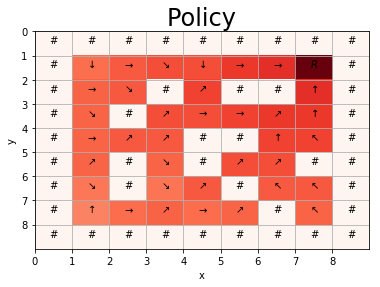

In [15]:
def plot_policy(env, agent, cfg, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_aspect("equal")
    
    # Handy variables
    maze_countours = maze.env.maze.matrix
    max_x = maze.env.maze.max_x
    max_y = maze.env.maze.max_y
    
    fitness_matrix = build_fitness_matrix(maze, agent.population, cfg)
    action_matrix = build_action_matrix(maze, agent.population, cfg)
    
    # Render maze as image
    plt.imshow(fitness_matrix, interpolation='nearest', cmap='Reds', aspect='auto',
           extent=[0, max_x, max_y, 0])
    
    
    # Add labels to each cell
    for (y,x), val in np.ndenumerate(action_matrix):
        plt.text(x+0.4, y+0.5, "${}$".format(val))
    
    ax.set_title("Policy", fontsize=24)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax.set_xlim(0, max_x)
    ax.set_ylim(max_y, 0)
    
    ax.set_xticks(range(0, max_x))
    ax.set_yticks(range(0, max_y))
    
    ax.grid(True)

plot_policy(maze, agent, cfg)
plt.savefig('maze_policy.eps', format='eps', dpi=100)

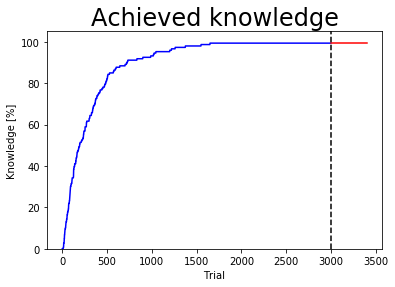

In [16]:
def plot_knowledge(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
        
    explore_df['knowledge'].plot(ax=ax, c='blue')
    exploit_df['knowledge'].plot(ax=ax, c='red')
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
        
    ax.set_title("Achieved knowledge", fontsize=24)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Knowledge [%]")
    ax.set_ylim([0, 105])

plot_knowledge(metrics_df)
plt.savefig('maze_knowledge.eps', format='eps', dpi=100)

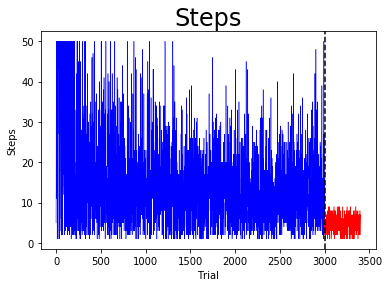

In [17]:
def plot_steps(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    explore_df['steps'].plot(ax=ax, c='blue', linewidth=.5)
    exploit_df['steps'].plot(ax=ax, c='red', linewidth=0.5)
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Steps", fontsize=24)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Steps")
    
plot_steps(metrics_df)
plt.savefig('maze_steps.eps', format='eps', dpi=100)

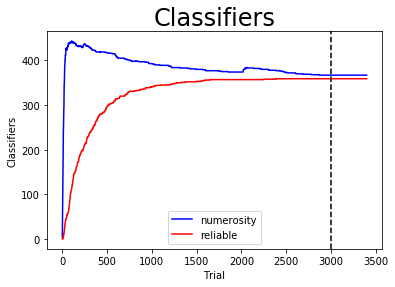

In [18]:
def plot_classifiers(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    df['numerosity'].plot(ax=ax, c='blue')
    df['reliable'].plot(ax=ax, c='red')    
    
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Classifiers", fontsize=24)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Classifiers")
    ax.legend()

plot_classifiers(metrics_df)
plt.savefig('maze_classifiers.eps', format='eps', dpi=100)

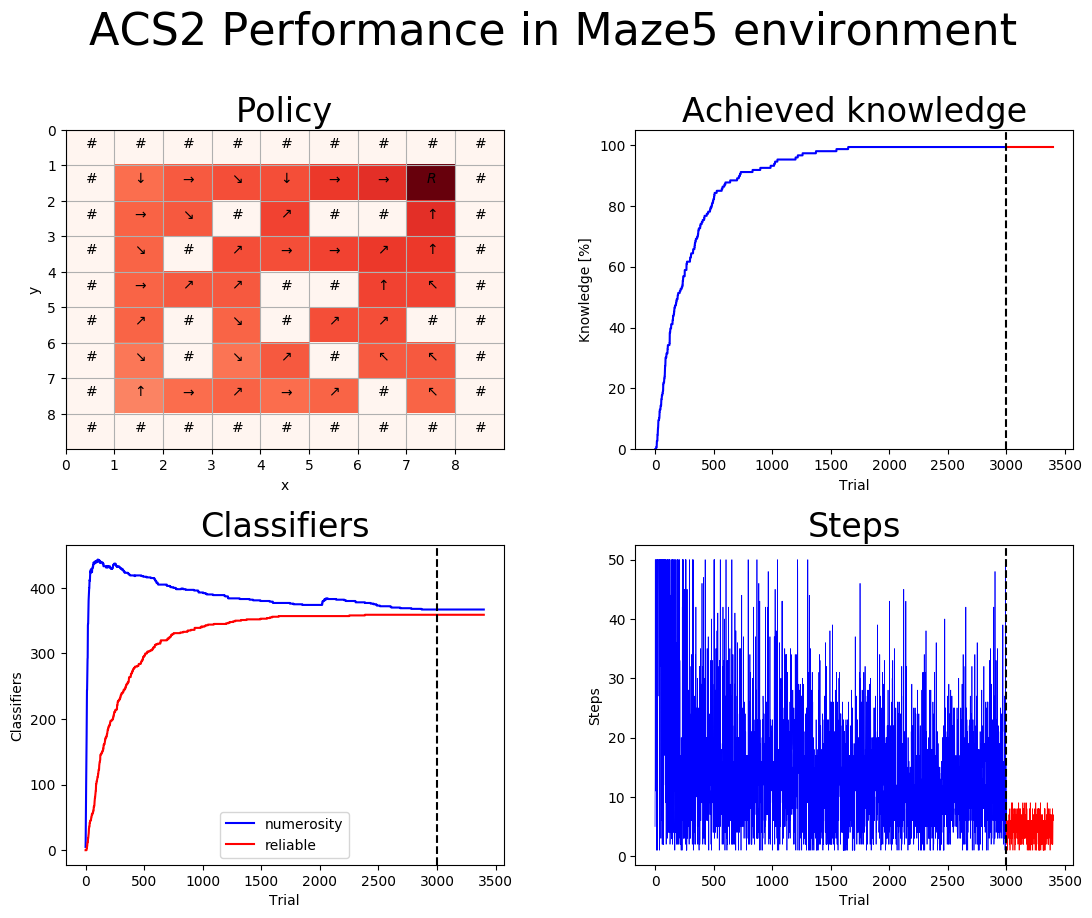

In [19]:
def plot_performance(agent, maze, metrics_df):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle('ACS2 Performance in Maze5 environment', fontsize=32)
    
    ax1 = plt.subplot(221)
    plot_policy(maze, agent, ax1)
    
    ax2 = plt.subplot(222)
    plot_knowledge(metrics_df, ax2)
    
    ax3 = plt.subplot(223)
    plot_classifiers(metrics_df, ax3)
    
    ax4 = plt.subplot(224)
    plot_steps(metrics_df, ax4)
    
    plt.subplots_adjust(top=0.86, wspace=0.3, hspace=0.3)
    plt.savefig('maze5_ev.eps', format='eps', dpi=100)
    plt.show()

plot_performance(agent, maze, metrics_df)